In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import *
slim = tf.contrib.slim
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="4"


## Hyperparam

In [2]:
params = dict(
    batch_size = 256,
    seed = 1234,
    z_dim = 100,
    x_dim = 784,
    reg_w = 0.,
    lr = 3e-3
)
rng = np.random.RandomState(params['seed'])  # seed labels

## Data creation

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
trainx = np.vstack([mnist.train.images,mnist.validation.images])
trainy = np.hstack([mnist.train.labels,mnist.validation.labels])
testx = mnist.test.images
testy = mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


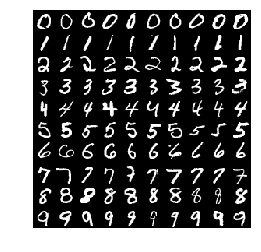

In [4]:
labeled =10
trainx_unl = trainx.copy()
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:labeled])
    tys.append(trainy[trainy == j][:labeled])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys

nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']

show_digits(trainx[:100])
plt.show()

In [5]:
from mnist_model import generator,discriminator

## Build model

In [6]:
tf.reset_default_graph()

In [7]:
unl_dataset = tf.data.Dataset.from_tensor_slices(trainx_unl)
unl_dataset = unl_dataset.shuffle(10000).repeat().batch(params['batch_size'])

train_dataset = tf.data.Dataset.from_tensor_slices((trainx, trainy))
train_dataset = train_dataset.shuffle(10000).repeat().batch(params['batch_size'])

test_dataset = tf.data.Dataset.from_tensor_slices((testx, testy))
test_dataset = test_dataset.repeat().batch(params['batch_size'])

iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
next_element, next_label = iterator.get_next()
training_init_op = iterator.make_initializer(train_dataset)
validation_init_op = iterator.make_initializer(test_dataset)

iterator_unl = unl_dataset.make_one_shot_iterator()
next_unl = iterator_unl.get_next()

In [15]:
is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
data = tf.cast(next_unl,tf.float32)
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
# Construct generator and discriminator net

samples = generator(noise,is_training_pl,reuse=tf.AUTO_REUSE)
real_score = discriminator(data,is_training_pl,reuse=tf.AUTO_REUSE)
fake_score = discriminator(samples,is_training_pl,reuse=tf.AUTO_REUSE)

# samples = generator(params['batch_size'])
# real_score = discriminator(data)
# fake_score = discriminator(samples)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

# optimizer = tf.train.RMSPropOptimizer(params['lr'])
optimizer = tf.train.AdamOptimizer(params['lr'])

d_grads = tf.gradients(loss, disc_vars)
g_grads = tf.gradients(-loss, gen_vars)

variables = disc_vars + gen_vars
grads = d_grads + g_grads

apply_vec = [(g, v)for (g, v) in zip(grads, variables)]
global_step = tf.Variable(0, name='global_step',trainable=False)
train_op = optimizer.apply_gradients(apply_vec, global_step=global_step)      

ValueError: Variable discriminator/layer_1/conv/kernel/Adam/ already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-8-91e4545e9dde>", line 33, in <module>
    train_op = optimizer.apply_gradients(apply_vec, global_step=global_step)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):


In [16]:
print(samples)

Tensor("generator_1/layer_5/tanh:0", shape=(256, 28, 28, 1), dtype=float32)


In [17]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [18]:
fs = []
frames = []
np_samples = []
n_batches_viz = 1
viz_every = 1000

for i in tqdm(range(20000)):
    f, _= sess.run([[loss], train_op],{is_training_pl:True})
    if (i) % viz_every == 0:
        xx, yy = sess.run([data,samples],{is_training_pl:False})
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        show_digits(xx[:100])
        plt.subplot(122)
        show_digits(yy[:100])
        plt.show()

HBox(children=(IntProgress(value=0, max=20000), HTML(value='')))

InvalidArgumentError: You must feed a value for placeholder tensor 'is_training_pl' with dtype bool
	 [[Node: is_training_pl = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: Mean_1/_65 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2799_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'is_training_pl', defined at:
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/tornado/ioloop.py", line 760, in _run_callback
    ret = callback()
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-91e4545e9dde>", line 1, in <module>
    is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1680, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3141, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/bruno/anaconda3/envs/tensorflow-1.5/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'is_training_pl' with dtype bool
	 [[Node: is_training_pl = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: Mean_1/_65 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2799_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
perturb = tf.random_normal([params['batch_size'],params['z_dim']], mean=0, stddev=1)
perturb = tf.nn.l2_normalize(perturb, dim=[1])
noise_pert = noise + 5 * perturb

# samples = generator(noise,is_training_pl)
samples_perturb = generator(noise_pert, is_training_pl,output_dim=params['x_dim'], reuse=True)

samp_adv = samples + 1 * tf.nn.l2_normalize(samples-samples_perturb,dim=[1])


In [ ]:
xx,yy = sess.run([samples,samples_perturb],{is_training_pl:False})

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
show_digits(xx)
plt.subplot(122)
show_digits(yy)
plt.show()